<a href="https://colab.research.google.com/github/andrew-veriga/Tensorflow-labs/blob/master/C4_W1_Lab_Stack_Semantics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stack Semantics in Trax: Ungraded Lab

В этой лабораторной работе без оценки мы разберем семантику стека в Trax. Она поможет понять, как использовать такие слои, как `Select` и `Residual`, которые работают с элементами в стеке. Из занятий по нформатике, вы помните, что стек - это структура данных, которая следует принципу «последний пришел - первым ушел» (LIFO). То есть, какой бы элемент ни был помещен в стек последним, он будет извлечен первым. Если вы еще не знакомы со стеками, вам может быть полезным это [краткое руководство] (https://www.tutorialspoint.com/python_data_structure/python_stack.htm). Вкратце, все, что вам действительно нужно помнить, это то, что он помещает элементы один поверх другого. Вам нужно помнить, какой элемент находится наверху стека, чтобы знать, что вы будете извлекать. Вы увидите это в обсуждениях ниже. Давайте начнем!

## Imports

In [ ]:
import numpy as np              # regular ol' numpy
from trax import layers as tl   # core building block
from trax import shapes         # data signatures: dimensionality and type
from trax import fastmath       # uses jax, offers numpy on steroids

## 1. Слой tl.Serial - стековый
Для понимания стековых вычислений в [Trax](https://trax-ml.readthedocs.io/en/latest/), в большинстве случаев здесь будет использоваться слой `Serial`. Мы определим два простых [слоя функций](https://trax-ml.readthedocs.io/en/latest/notebooks/layers_intro.html?highlight=fn#With-the-Fn-layer-creating-function.): 1) Addition (сложение) и 2) Multiplication (произведение).

Предположим, мы хотим произвести простое вычисление (3 + 4) * 15 + 3. Слой `Serial` будет выполнять вычисления следующим образом: `3` `4` `add` `15` `mul` `3` `add`. Шаги расчета показаны в таблице ниже. В первом столбце показаны операции, выполненные в стеке, а во втором столбце - результаты этих операций. Кроме того, правый элемент во втором столбце представляет вершину стека (например, во второй строке `Push (3)` выталкивает `3` вверх стека, и теперь ` 4` находится под ним).

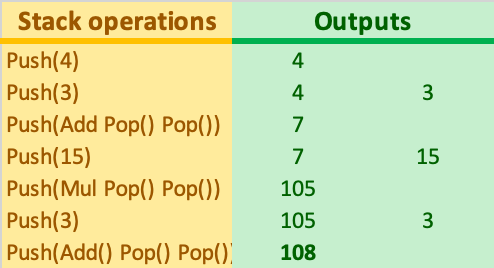

 
После окончания процедуры стек содержит `108`, что и будет результатом наших простых вычислений.

Из этого можно сделать следующий вывод: слой на основе стека имеет только один способ обработки данных: взятие одного фрагмента данных из вершины стека, `pop`, и помещением данных обратно в стек - `push`. Любое выражение, которое может быть записано традиционным способом, может быть записано и в такой форме таким образом, оно может быть интерпретировано стековым слоем, таким как `Serial`.**bold text**

### Coding the example in the table:

**Определим сложение**

In [ ]:
def Addition():
    layer_name = "Addition"  # don't forget to give your custom layer a name to identify

    # Custom function for the custom layer
    def func(x, y):
        return x + y

    return tl.Fn(layer_name, func)


# Test it
add = Addition()

# Inspect properties
print("-- Properties --")
print("name :", add.name)
print("expected inputs :", add.n_in)
print("promised outputs :", add.n_out, "\n")

# Inputs
x = np.array([3])
y = np.array([4])
print("-- Inputs --")
print("x :", x, "\n")
print("y :", y, "\n")

# Outputs
z = add((x, y))
print("-- Outputs --")
print("z :", z)

**Определим произведение**

In [ ]:
def Multiplication():
    layer_name = (
        "Multiplication"  # don't forget to give your custom layer a name to identify
    )

    # Custom function for the custom layer
    def func(x, y):
        return x * y

    return tl.Fn(layer_name, func)


# Test it
mul = Multiplication()

# Inspect properties
print("-- Properties --")
print("name :", mul.name)
print("expected inputs :", mul.n_in)
print("promised outputs :", mul.n_out, "\n")

# Inputs
x = np.array([7])
y = np.array([15])
print("-- Inputs --")
print("x :", x, "\n")
print("y :", y, "\n")

# Outputs
z = mul((x, y))
print("-- Outputs --")
print("z :", z)

**Выполнение вычислений с использованием комбинатора Serial.**

In [ ]:
# Serial combinator
serial = tl.Serial(
    Addition(), Multiplication(), Addition()  # add 3 + 4  # multiply result by 15
)

# Initialization
x = (np.array([3]), np.array([4]), np.array([15]), np.array([3]))  # input

serial.init(shapes.signature(x))  # initializing serial instance


print("-- Serial Model --")
print(serial, "\n")
print("-- Properties --")
print("name :", serial.name)
print("sublayers :", serial.sublayers)
print("expected inputs :", serial.n_in)
print("promised outputs :", serial.n_out, "\n")

# Inputs
print("-- Inputs --")
print("x :", x, "\n")

# Outputs
y = serial(x)
print("-- Outputs --")
print("y :", y)

The example with the two simple adition and multiplication functions that where coded together with the serial combinator show how stack semantics work in `Trax`.

Пример с двумя простыми функциями сложения и умножения, которые закодированы вместе с комбинатором `Serial`, показывает, как семантика стека работает в `Trax`.

## 2. Комбинатор tl.Select в контексте комбинатора Serial

Поняв, как семантика стека работает в `Trax`, мы продемонстрируем, как работает комбинатор [tl.Select](https://trax-ml.readthedocs.io/en/latest/trax.layers.html?highlight=select#trax.layers.combinators.Select).

### Первый пример `tl.Select`

Предположим, мы хотим произвести простое вычисление (3 + 4) * 3 + 4. Мы можем использовать `Select` для выполнения вычислений следующим образом:

1. `4`
2. `3`
3. `tl.Select([0,1,0,1])` 
4. `add` 
5. `mul` 
6. `add`. 

The `tl.Select` requires a list or tuple of 0-based indices to select elements relative to the top of the stack. For our example, the top of the stack is `3` (which is at index 0) then `4` (index 1) and we Select to add in an ordered manner to the top of the stack which after the command is `3` `4` `3` `4`. The steps of the calculation for our example are shown in the table below. As in the previous table each column shows the contents of the stack and the outputs after the operations are carried out.

Для tl.Select требуется список или кортеж индексов с отсчетом от 0 для выбора элементов из вершины стека. В нашем примере вершина стека - это «3» (с индексом 0), затем «4» (индекс 1), и мы выполняем `Select`, чтобы добавить в упорядоченном виде к вершине стека, которая после выполнения получает значение `3` `4` `3` `4`. Шаги расчета для нашего примера показаны в таблице ниже. Как и в предыдущей таблице, каждый столбец показывает содержимое стека и результаты выполнения операций.

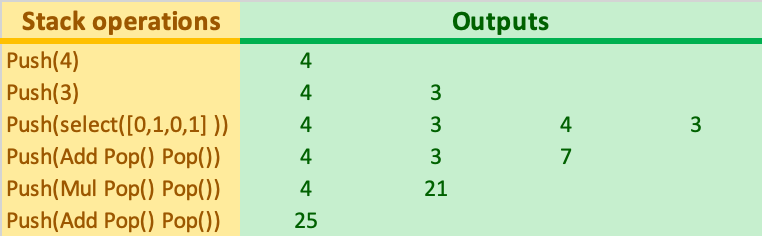

После обработки всех входных данных стек содержит значение `25` - ответ, который мы получили выше.

In [ ]:
serial = tl.Serial(tl.Select([0, 1, 0, 1]), Addition(), Multiplication(), Addition())

# Initialization
x = (np.array([3]), np.array([4]))  # input

serial.init(shapes.signature(x))  # initializing serial instance


print("-- Serial Model --")
print(serial, "\n")
print("-- Properties --")
print("name :", serial.name)
print("sublayers :", serial.sublayers)
print("expected inputs :", serial.n_in)
print("promised outputs :", serial.n_out, "\n")

# Inputs
print("-- Inputs --")
print("x :", x, "\n")

# Outputs
y = serial(x)
print("-- Outputs --")
print("y :", y)

### Второй пример `tl.Select`

Предположим, мы хотим произвести простое вычисление (3 + 4) * 4. Мы можем использовать `Select` для выполнения вычислений следующим образом:

1. `4`
2. `3`
3. `tl.Select([0,1,0,1])` 
4. `add` 
5. `tl.Select([0], n_in=2)`
6. `mul`

Пример немного надуманный, но он демонстрирует гибкость этой команды. Второй `tl.Select` вынимает два элемента (указанных в n_in) из стека, начиная с индекса 0 (то есть с вершины стека). Это означает, что будут вынуты `7` и` 3`, потому что `n_in = 2`), но только `7` помещается обратно вверх, потому что он выбирает только `[0]`. Как и в предыдущей таблице, каждый столбец показывает содержимое стека и результаты выполнения операций.
<div style="text-align:center" width="20px"><img src="https://github.com/andrew-veriga/Tensorflow-labs/blob/master/Stack3.png?raw=1" /></div>


После обработки всех входных данных в стеке сидит число 28 - это наш ответ.

In [ ]:
serial = tl.Serial(
    tl.Select([0, 1, 0, 1]), Addition(), tl.Select([0], n_in=2), Multiplication()
)

# Initialization
x = (np.array([3]), np.array([4]))  # input

serial.init(shapes.signature(x))  # initializing serial instance


print("-- Serial Model --")
print(serial, "\n")
print("-- Properties --")
print("name :", serial.name)
print("sublayers :", serial.sublayers)
print("expected inputs :", serial.n_in)
print("promised outputs :", serial.n_out, "\n")

# Inputs
print("-- Inputs --")
print("x :", x, "\n")

# Outputs
y = serial(x)
print("-- Outputs --")
print("y :", y)

**В итоге, то, что Select делает в этом примере - это копия входных данных для дальнейшего использования в стеке операций.**

## 3. Комбинатор tl.Residual в контексте комбинатора Serial 

### tl.Residual

[Residual networks](https://arxiv.org/pdf/1512.03385.pdf) Часто используются для облегчения обучения глубоких моделей, и вы также будете использовать их в задании. В `Trax` уже есть встроенный слой для этого. [Residual layer](https://trax-ml.readthedocs.io/en/latest/trax.layers.html?highlight=residual#trax.layers.combinators.Residual) вычисляет поэлементно *сумму* входа *stack-top* с выходом ряда слоев. Давайте сначала посмотрим, как это используется в приведенном ниже коде:

In [ ]:
# Let's define a Serial network
serial = tl.Serial(
    # Practice using Select again by duplicating the first two inputs
    tl.Select([0, 1, 0, 1]),
    # Place a Residual layer that skips over the Fn: Addition() layer
    tl.Residual(Addition())
)

print("-- Serial Model --")
print(serial, "\n")
print("-- Properties --")
print("name :", serial.name)
print("expected inputs :", serial.n_in)
print("promised outputs :", serial.n_out, "\n")

Here, we use the Serial combinator to define our model. The inputs first goes through a `Select` layer, followed by a `Residual` layer which passes the `Fn: Addition()` layer as an argument. What this means is the `Residual` layer will take the stack top input at that point and add it to the output of the `Fn: Addition()` layer. You can picture it like the diagram the below, where `x1` and `x2` are the inputs to the model:

Здесь мы используем комбинатор Serial для определения нашей модели. Входные данные сначала проходят слой `Select`, а затем слой `Residual`, который передает слой `Fn: Addition()` в качестве аргумента. Это означает, что слой `Residual` будет принимать вход вершины стека в этой точке и складывать его к с выходом слоя`Fn: Addition() `. Вы можете изобразить это как на диаграмме ниже, где `x1` и` x2` - входные данные для модели:

<img src="https://github.com/andrew-veriga/Tensorflow-labs/blob/master/residual_example_add.png?raw=1" width="400"/></div>

Теперь давайте попробуем запустить нашу модель с некоторыми примерами входных данных и посмотрим результат:

In [ ]:
# Inputs
x1 = np.array([3])
x2 = np.array([4])
print("-- Inputs --")
print("(x1, x2) :", (x1, x2), "\n")

# Outputs
y = serial((x1, x2))
print("-- Outputs --")
print("y :", y)

Как вы можете видеть, слой `Residual` запоминает вершину стека (то есть `3`) и добавляет его к результату слоя `Fn: Addition()` (т.е. `3 + 4 = 7`). Выход `Residual(Addition())` равен `3 + 7 = 10` и укладывается в стек.

С другой стороны, вы заметите, что слой `Select` имеет 4 выхода, но слой`Fn: Addition()` извлекает только 2 входа из стека. Это означает, что повторяющиеся входы (т.е. 2 крайние правые стрелки выходов `Select` на рисунке выше) остаются в стеке. Вот почему вы до сих пор видите его в выходных данных нашей простой последовательной сети (т.е. `array ([3]), array ([4])`). Это полезно, если вы хотите использовать эти повторяющиеся входные данные на другом слое дальше по сети.

### Модификация сети


Чтобы лучше понять, вы можете изменить приведенную выше сеть и исследовать полученные результаты. Например, вы можете передать слой `Fn: Multiplication()` вместо блока `Residual`:

In [ ]:
# model definition
serial = tl.Serial(
    tl.Select([0, 1, 0, 1]), 
    tl.Residual(Multiplication())
)

print("-- Serial Model --")
print(serial, "\n")
print("-- Properties --")
print("name :", serial.name)
print("expected inputs :", serial.n_in)
print("promised outputs :", serial.n_out, "\n")

Это означает, что у вас будет другой вывод, который будет добавлен к входу вершины стека, сохраненному блоком Residual. Схема становится такой:

<img src="https://github.com/andrew-veriga/Tensorflow-labs/blob/master/residual_example_multiply.png?raw=1" width="400"/></div>

И вы получите `3 + (3 * 4) = 15` как вывод блока `Residual`:

In [ ]:
# Inputs
x1 = np.array([3])
x2 = np.array([4])
print("-- Inputs --")
print("(x1, x2) :", (x1, x2), "\n")

# Outputs
y = serial((x1, x2))
print("-- Outputs --")
print("y :", y)

#### Поздравляю! В этой лабораторной работе мы описали, как семантика стека работает со слоями Trax, такими как Select и Residual. Вы будете использовать их в задании и можете вернуться к этой лабораторной работе, если захотите проверить их использование.